In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
valset = datasets.MNIST('./', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

#Note: batch size is the number of images we want to read in one go.

100.1%

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


113.5%

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


180.4%

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape) #64 images in each batch and each image has a dimension of 28 x 28 pixels
print(labels.shape) #64 images should have 64 labels

torch.Size([64, 1, 28, 28])
torch.Size([64])


(-0.5, 27.5, 27.5, -0.5)

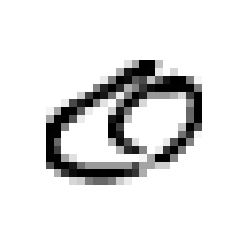

In [26]:
#look at one image
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.axis('off')


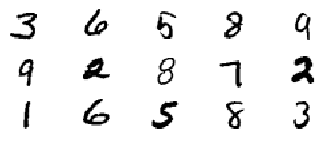

In [27]:
figure = plt.figure()
num_of_images = 15
for index in range(1, num_of_images + 1):
    plt.subplot(5, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [12]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [28]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [14]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0024, -0.0024, -0.0024,  ..., -0.0024, -0.0024, -0.0024],
        [ 0.0021,  0.0021,  0.0021,  ...,  0.0021,  0.0021,  0.0021],
        [-0.0037, -0.0037, -0.0037,  ..., -0.0037, -0.0037, -0.0037],
        ...,
        [-0.0024, -0.0024, -0.0024,  ..., -0.0024, -0.0024, -0.0024],
        [ 0.0027,  0.0027,  0.0027,  ...,  0.0027,  0.0027,  0.0027],
        [-0.0025, -0.0025, -0.0025,  ..., -0.0025, -0.0025, -0.0025]])


In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.6118436225139892
Epoch 1 - Training loss: 0.28843464090752957
Epoch 2 - Training loss: 0.2282014431904501
Epoch 3 - Training loss: 0.18500062364981626
Epoch 4 - Training loss: 0.153775980437933
Epoch 5 - Training loss: 0.13264421940342322
Epoch 6 - Training loss: 0.11494109799354665
Epoch 7 - Training loss: 0.10108062120349105
Epoch 8 - Training loss: 0.09140508335782711
Epoch 9 - Training loss: 0.08274836217297483
Epoch 10 - Training loss: 0.07599490475622432
Epoch 11 - Training loss: 0.06890766852563109
Epoch 12 - Training loss: 0.06382578510521993
Epoch 13 - Training loss: 0.058313616471531896
Epoch 14 - Training loss: 0.05395344530851809

Training Time (in minutes) = 2.5045966506004333


In [20]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9745


In [29]:
torch.save(model, './my_mnist_model.pt') 

/Users/jdehart/Library/Python/3.7/lib/python/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/jdehart/Library/Python/3.7/lib/python/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/jdehart/Library/Python/3.7/lib/python/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/jdehart/Library/Python/3.7/lib/python/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogSoftmax. It won't be checked for correctness upon loading